# 5 classes - no sad no angry
https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50?select=resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os

In [4]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [24]:
%mkdir data5cls

In [27]:
%cp -r /notebooks/data7cls_newimg_randomsplit/train /notebooks/data5cls
%cp -r /notebooks/data7cls_newimg_randomsplit/validation /notebooks/data5cls

In [34]:
%cd /notebooks/data5cls/train

/notebooks/data5cls/train


In [35]:
!rm -r '.ipynb_checkpoints'

In [36]:
%cd /notebooks/data5cls/validation
!rm -r '.ipynb_checkpoints'

/notebooks/data5cls/validation


In [5]:
# Fixed classes
NUM_CLASSES = 5
CHANNELS = 3

IMAGE_RESIZE = 48
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [6]:
resnet_weights_path = '/notebooks/W251_FinalProject/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
download = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [7]:
#Still not talking about our train/test data or any pre-processing.
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = "imagenet"))

# 2nd layer as Dense for 7-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
from tensorflow.python.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)

#previous code it is just optimizer=sgd, here i have to use 'sgd' with quotaiton, otherwise the code is not running at fit)
#for this part, i think i am using default sgd??
model.compile(optimizer = 'sgd', loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [23]:
# ! rmdir /notebooks/data7cls_newing_randomsplit/train/.ipynb_checkpoints
# ! rmdir /notebooks/data7cls_newing_randomsplit/validation/.ipynb_checkpoints

rmdir: failed to remove '/notebooks/data7cls_newing_randomsplit/train/.ipynb_checkpoints': No such file or directory
rmdir: failed to remove '/notebooks/data7cls_newing_randomsplit/validation/.ipynb_checkpoints': No such file or directory


In [10]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
image_size = IMAGE_RESIZE

train_dir1 = "/notebooks/data5cls/train/"
valid_dir1 = "/notebooks/data5cls/validation/"

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# val_datagen = ImageDataGenerator(rescale=1./255)
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#       rotation_range=30,
#       shear_range=0.3,
#       zoom_range=0.3,
#       horizontal_flip=True,
#       fill_mode='nearest')

train_generator = data_generator.flow_from_directory(
        train_dir1,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        valid_dir1,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Using TensorFlow backend.


Found 16654 images belonging to 5 classes.
Found 4164 images belonging to 5 classes.


In [11]:
print(validation_generator.class_indices)

{'happy': 2, 'confused': 0, 'neutral': 3, 'surprise': 4, 'distracted': 1}


In [12]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 167, 100, 42)

In [13]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
#cb_checkpointer = ModelCheckpoint(filepath = '/notebooks/W251_FinalProject/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')
cb_checkpointer = ModelCheckpoint(filepath = '/notebooks/5cls.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [57]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [14]:
# import keras
# filepath = os.path.join("/notebooks/littleVGG7cls/model_transferlearn_{epoch}.hdf5")

# checkpoint = keras.callbacks.ModelCheckpoint(filepath,
#                                              monitor='val_acc',
#                                              verbose=1,
#                                              save_best_only=True,
#                                              mode='max')
# callbacks = [checkpoint]

fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]

)
#model.load_weights('/notebooks/W251_FinalProject/best.hdf5')



Epoch 1/10


W0712 02:59:20.276017 140329087477504 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/ops/math_grad.py:1394: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


10/10 [==============================] - 28s 3s/step - loss: 1.9034 - accuracy: 0.3170 - val_loss: 2.1275 - val_accuracy: 0.3850
Epoch 2/10
10/10 [==============================] - 28s 3s/step - loss: 1.5465 - accuracy: 0.4270 - val_loss: 2.0516 - val_accuracy: 0.4000
Epoch 3/10
10/10 [==============================] - 28s 3s/step - loss: 1.4392 - accuracy: 0.4440 - val_loss: 2.1701 - val_accuracy: 0.4150
Epoch 4/10
10/10 [==============================] - 29s 3s/step - loss: 1.3893 - accuracy: 0.4650 - val_loss: 1.9860 - val_accuracy: 0.4080
Epoch 5/10
10/10 [==============================] - 28s 3s/step - loss: 1.2759 - accuracy: 0.4860 - val_loss: 2.0341 - val_accuracy: 0.4340
Epoch 6/10
10/10 [==============================] - 28s 3s/step - loss: 1.3036 - accuracy: 0.5010 - val_loss: 1.9495 - val_accuracy: 0.4230
Epoch 7/10
10/10 [==============================] - 28s 3s/step - loss: 1.2827 - accuracy: 0.4790 - val_loss: 1.9609 - val_accuracy: 0.4280
Epoch 8/10
10/10 [=============

In [64]:
%cd ..

/notebooks


In [15]:
SAVER = "../notebooks/model_save"
model.save(os.path.join(SAVER, "5clsmodel.h5"))  #saving the model on each epoc
#model.save_weights(os.path.join(SAVER, "model_weights.h5")) #saving the weights of model on each epoch

In [18]:
nb_validation_samples /batch_size

4165.0

Found 4164 images belonging to 5 classes.
Confusion Matrix
[[  0   0  79  83   0]
 [  0   0  34 129   1]
 [  0   1 871 918  35]
 [  0   3 367 812  34]
 [  0   4 150 495 148]]
Classification Report
              precision    recall  f1-score   support

    confused       0.00      0.00      0.00       162
  distracted       0.00      0.00      0.00       164
       happy       0.58      0.48      0.52      1825
     neutral       0.33      0.67      0.44      1216
    surprise       0.68      0.19      0.29       797

    accuracy                           0.44      4164
   macro avg       0.32      0.27      0.25      4164
weighted avg       0.48      0.44      0.42      4164



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


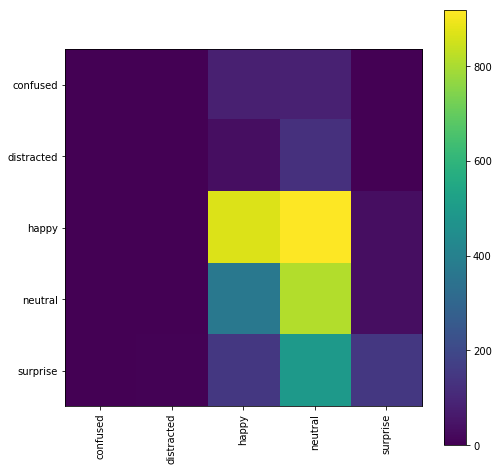

In [21]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
#Found 16654 images belonging to 5 classes.
#Found 4164 images belonging to 5 classes.
nb_train_samples = 16654
nb_validation_samples = 4164
batch_size=BATCH_SIZE_TESTING
# We need to recreate our validation generator with shuffle = false
validation_generator = data_generator.flow_from_directory(
        directory = '/notebooks/data5cls/validation',
        #color_mode = 'grayscale',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TESTING,
        class_mode='categorical',
        shuffle=False,
        seed=123)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, 4164)
                                 #nb_validation_samples /batch_size)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [82]:
cnf_matrix

array([[367,   3,   3, 151, 256, 118,  62],
       [  3, 148,   4,   3,   3,   1,   0],
       [  2,  20, 129,   3,   8,   0,   2],
       [411,   6,   4, 756, 416, 130, 102],
       [283,   4,   0, 207, 544, 100,  78],
       [292,   3,   0, 221, 348, 223,  52],
       [145,   2,   0, 100, 141,  38, 371]])

In [83]:
cm=cnf_matrix
cm = cm.astype('float') / cm.sum(axis=1)[:,None]
cm

array([[0.38229167, 0.003125  , 0.003125  , 0.15729167, 0.26666667,
        0.12291667, 0.06458333],
       [0.01851852, 0.91358025, 0.02469136, 0.01851852, 0.01851852,
        0.00617284, 0.        ],
       [0.01219512, 0.12195122, 0.78658537, 0.01829268, 0.04878049,
        0.        , 0.01219512],
       [0.22520548, 0.00328767, 0.00219178, 0.41424658, 0.22794521,
        0.07123288, 0.05589041],
       [0.23273026, 0.00328947, 0.        , 0.17023026, 0.44736842,
        0.08223684, 0.06414474],
       [0.25636523, 0.00263389, 0.        , 0.19402985, 0.30553117,
        0.19578578, 0.04565408],
       [0.18193225, 0.00250941, 0.        , 0.12547051, 0.17691343,
        0.0476788 , 0.46549561]])

KeyError: 'acc'

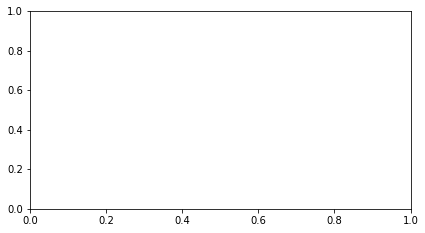

In [22]:
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

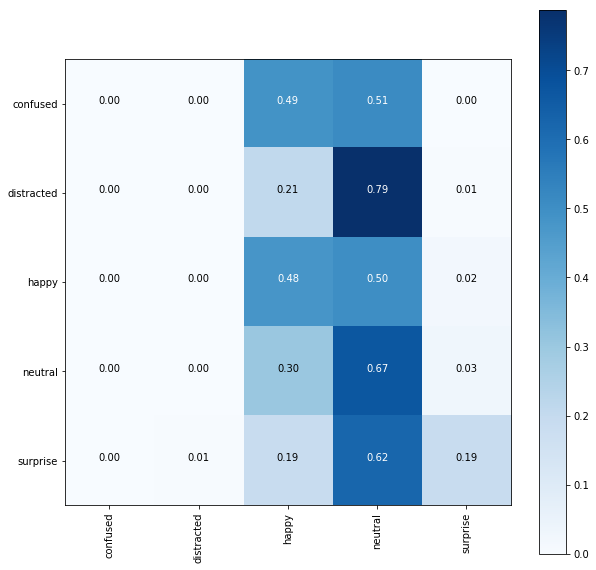

In [23]:
import itertools
cm=cnf_matrix
cm = cm.astype('float') / cm.sum(axis=1)[:,None]
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")